# Set up farm run

In [1]:
# Load the amrwind-frontend module
# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/projects/wind_uq/lcheung/amrwind-frontend',
                 '/ascldap/users/lcheung/wind_uq/amrwind-frontend/',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)

# Load the libraries
import amrwind_frontend  as amrwind
import matplotlib.pyplot as plt
import numpy             as np
import math
import pandas as pd
import postproamrwindsample as ppsample
import time
import utm

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

In [2]:
verbose=False

In [3]:
if verbose:
    for x in amrwindfedirs:
        if os.path.exists(x+"/turbines/summitlayoutturbs.yaml"):
            with open(x+"/turbines/summitlayoutturbs.yaml") as f: print(f.read())

In [4]:
def updateturbdf(df, csvfile, col, numhead=1, splitdelim=None):
    csvdat      = [line.strip().split(splitdelim) for line in open(csvfile, 'r')][numhead:]
    for row in csvdat:
        turbname = row[0]
        val      = row[1]
        df.loc[df['# name'] == turbname, col]  = val
    return df

def updateturbs(df, changeKPturb='', numhead=1, splitdelim=None):
    KPcsvfile = 'KP_turbine_yaw.txt'
    df        = updateturbdf(df, KPcsvfile, ' yaw')
    # Change the KP turb type if necessary
    if len(changeKPturb)>0:
        csvdat    = [line.strip().split(splitdelim) for line in open(KPcsvfile, 'r')][numhead:]
        for row in csvdat:
            turbname = row[0]
            df.loc[df['# name'] == turbname, ' type']  = changeKPturb
    return df

def removeturbines(runcase):
    physics = runcase.getAMRWindInput('incflo.physics')
    if 'Actuator' in physics:
        physics.remove('Actuator')
        runcase.setAMRWindInput('physics', physics)
        print('SET incflo.physics: '+repr(runcase.getAMRWindInput('incflo.physics')))
    runcase.setAMRWindInput('ActuatorForcing', False)    
    runcase.listboxpopupwindict['listboxactuator'].deleteall()
    return

In [5]:
# Start the AMR-Wind case
#rundir = '/ccs/home/lcheung/scratch.cfd162/AWAKEN/UnstableABL1_farmrun1'
case = amrwind.MyApp.init_nogui()

In [6]:
#precursordir  = '/ccs/home/lcheung/scratch.cfd162/AWAKEN/UnstableABL1_precursor2'
precursordir = '/gpfs/lcheung/AWAKEN/TCF_smallcase/precursor'

#precursorsetup= precursordir+'/UnstableABL_precursor2.inp'
precursorsetup= './UnstableABL_precursorSmall.inp'

cwd              = os.getcwd()
farmrundir       = './' #'/ccs/home/lcheung/cfd162/lcheung/AWAKEN_summit_setup/UnstableABL_farmrun1/template'
#'/gpfs/alpine/cfd162/scratch/lcheung/AWAKEN/test/testOFfarmrun'
outputfile       = 'UnstableABL_farmrun1.inp'
noturboutputfile = 'UnstableABL_farmrun1_noturbs.inp'

# # Make a copy of the precursor input for posterity
# try:
#    shutil.copy2(precursorsetup, './')
#except:
#    pass

# Load the starting point
case.loadAMRWindInput(precursorsetup)

CANNOT update: ABLMeanBoussinesq use forcechange=True in setval()


OrderedDict()

In [7]:
# Set the run duration
tstart = 15000     
tstop  = 15000+900
textra = 500

In [8]:
# Set the time constants
case.setAMRWindInput('time.stop_time', tstop+textra)
case.setAMRWindInput('time.fixed_dt', 0.1)
case.setAMRWindInput('time.max_step',  -1)

In [9]:
# Set the restart point
chkdir = precursordir+'/chk60000/'
case.setAMRWindInput('restart_file', os.path.realpath(chkdir))

In [10]:
# Set the boundary input file parameters
ablstatfile = precursordir+'/post_processing/abl_statistics00000.nc'
tavg        =  [tstart, tstop]
forcingdict = {'ablstatfile':ablstatfile, 'tavg':tavg}
inflowplanes= ['ylo'] #['ylo', 'xhi']
bndryfiles  = precursordir+'/bndry_fdata'

In [11]:
case.boundaryplane_restart(bndryfiles=bndryfiles, 
                           forcingdict=forcingdict, 
                           inflowplanes=inflowplanes, 
                           verbose=True)

SET ABL_bndry_io_mode = '1'
SET ABL_bndry_file = '/gpfs/lcheung/AWAKEN/TCF_smallcase/precursor/bndry_fdata'
SET ABL_bndry_planes = ['ylo']
SET is_periodicy = False
SET ylo_type = 'mass_inflow'
SET ylo_density = 1.17
SET ylo_temperature = 0.0
SET ylo_tke = 0.0
SET yhi_type = 'pressure_outflow'
SET yhi_density = None
SET yhi_temperature = None
SET yhi_tke = None
SET BodyForce = True
SET BodyForce_magnitude = [-0.0008382055615472171, 0.00017692470106951357, 0.0]
SET ABLForcing = False
SET ABLMeanBoussinesq = True
SET wall_shear_stress_type = 'local'


## Add turbines

In [12]:
#gitrepo            = '/autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/precursor/UnstableABL1/'
summitcsv          = 'UnstableABL_precursorSmall_turbines.csv'

# Use this to load the csv directly
#case.loadTurbineCSVFile(summitcsv)

In [13]:
# Load the data from the database of all turbines
allturbsdf = pd.read_csv(summitcsv, low_memory=False)
#allturbsdf = updateturbs(allturbsdf)
turbinescsvstring = allturbsdf.to_csv(index=False)
case.setAMRWindInput('turbines_csvtextbox',  turbinescsvstring)

In [14]:
case.setAMRWindInput('turbines_createnewdomain', False)
case.setAMRWindInput('turbines_deleteprev', True)

case.turbines_createAllTurbines()

# Print out existing list of turbines, just to confirm that the turbines got made
print(case.listboxpopupwindict['listboxactuator'].getitemlist())

['2016-WTW-14542-TR', '2016-WTW-14589-TR', '2016-WTW-14595-TR', '2016-WTW-14559-TR', '2016-WTW-14594-TR', '2016-WTW-14590-TR', '2016-WTW-14564-TR', '2016-WTW-14587-TR', '2016-WTW-14546-TR', '2016-WTW-14592-TR', '2016-WTW-14545-TR', '2016-WTW-14535-TR', '2016-WTW-14588-TR', '2016-WTW-14558-TR', '2016-WTW-14536-TR', '2016-WTW-14593-TR']


## Add refinement regions

In [15]:
refinementcsv="""
# CSV file should have columns with
# level, upstream, downstream, lateral, below, above, options
level, upstream, downstream, lateral, below, above, options
#0,     30000,    30000,      40000,  100,  1000,      center:farm units:meter
#1,  10000,    7500,    21000,  100,  250, center:specified units:meter centerx:653000 centery:4050000 centerz:100 name:TR
#1,   7500,    6500,    12500,  100,  250, center:specified units:meter centerx:640000 centery:4030000 centerz:100 name:KP
#1,  11000,    9000,    12500,  100,  250, center:specified units:meter centerx:630000 centery:4018000 centerz:100 name:AF
#1,   4000,    3000,     9000,  100,  250, center:specified units:meter centerx:618000 centery:4035000 centerz:100 name:BR
#1,  10000,    5000,    14000,  100,  250, center:specified units:meter centerx:618000 centery:4050000 centerz:100 name:CV
1,     1.0,    1.0,     1.0,    0.75,  0.75, orientation:nacdir
2,     0.6,    0.6,     0.6,    0.525, 0.525, orientation:nacdir
"""
case.setAMRWindInput('refine_csvtextbox', refinementcsv)
case.setAMRWindInput('refine_deleteprev', False)

In [16]:
case.refine_createAllZones()

In [17]:
# Estimate mesh size
case.estimateMeshSize(verbose=False)

ESTIMATED MESH SIZE
   Level       Ncells                      Cell Size
       0     33554432             20.0 x 20.0 x 20.0
       1     59400000             10.0 x 10.0 x 10.0
       2      1198768                5.0 x 5.0 x 5.0
       3      2416704                2.5 x 2.5 x 2.5
  TOTAL:     96569904


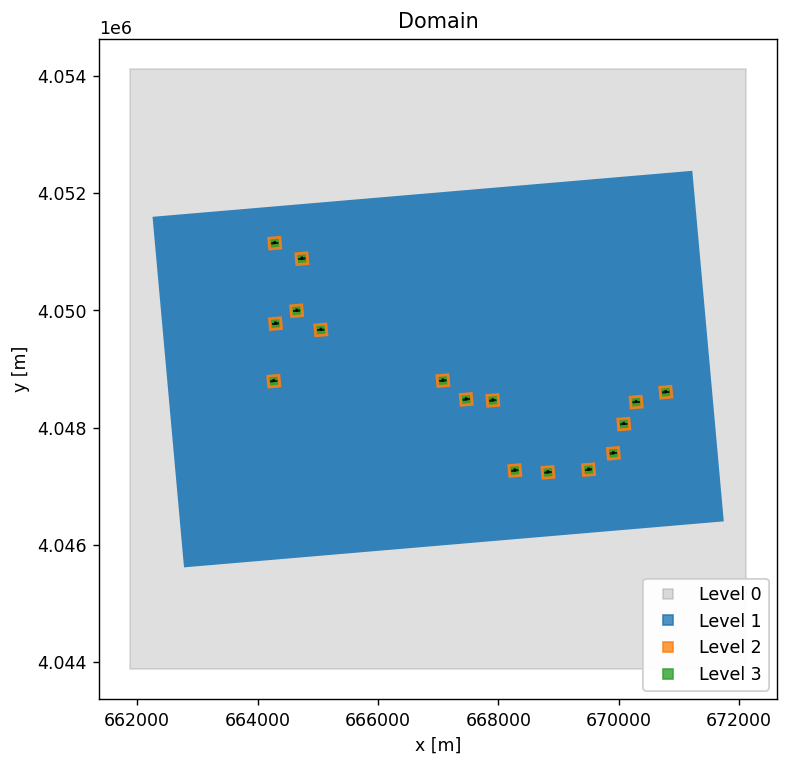

In [18]:
# Plot the domain
fig, ax = plt.subplots(figsize=(7,7), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_windnortharrows'] = False
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = [] #['p_hub']
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY'#'YZ' 
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.plotDomain(ax=ax)
ax.set_aspect('auto')


## Set up averaging

In [19]:
# Delete all old sampling planes from precursor
case.listboxpopupwindict['listboxsampling'].deleteall()
case.listboxpopupwindict['listboxpostprosetup'].deleteall()
print(case.listboxpopupwindict['listboxsampling'].getitemlist())
print(case.listboxpopupwindict['listboxpostprosetup'].getitemlist())

[]
[]


In [20]:
# Set up averaging
avgsetup = case.get_default_postprosetupdict() 
avgsetup['postprocessing_setup_name']             = 'averaging'
avgsetup['postprocessing_setup_type']             = 'TimeAveraging'
avgsetup['postprocessing_setup_averaging_window']     = 60.0
avgsetup['postprocessing_setup_averaging_start_time'] = tstart
avgsetup['postprocessing_setup_averaging_stop_time']  = 1.0E6
#case.add_populatefromdict('listboxpostprosetup', avgsetup, verbose=True)
case.add_postprosetup(avgsetup, verbose=True)

postprocessing_setup_name: 'averaging'
postprocessing_setup_type: 'TimeAveraging'
postprocessing_setup_output_frequency: 100
postprocessing_setup_fields: 'velocity'
postprocessing_setup_averaging_window: 60.0
postprocessing_setup_averaging_start_time: 15000
postprocessing_setup_averaging_stop_time: 1000000.0


In [21]:
avgobject                             = case.get_default_averagingdict()
avgobject['averaging_name']           = 'mean_average'
avgobject['averaging_averaging_type'] = 'ReAveraging'
avgobject['averaging_fields']         = 'velocity'
case.add_averaging(avgobject, verbose=True)

averaging_name: 'mean_average'
averaging_outputto: 'averaging'
averaging_averaging_type: 'ReAveraging'
averaging_fields: 'velocity'


In [22]:
# # Set up averaging
# metmastpprosetup = case.get_default_postprosetupdict()
# metmastpprosetup['postprocessing_setup_name'] = 'metmast_'
# metmastpprosetup['postprocessing_setup_type'] = 'Sampling'
# metmastpprosetup['postprocessing_setup_output_frequency'] =  1
# metmastpprosetup['postprocessing_setup_fields']           =  'velocity'
# case.add_postprosetup(metmastpprosetup, verbose=True)

## Add sampling planes

In [23]:
farm_domainsize = [10240, 10240, 2560]
farm_center     = [667000, 4049000]   # In utm

In [24]:
outputoptions="outputvars:velocity;tke;temperature;velocity_mean outputfreq:10"

samplingcsv = """
# CSV file should have columns withturbinescsv=
# name, type, upstream, downstream, lateral, below, above, n1, n2, options
name, type, upstream, downstream, lateral, below, above, n1, n2, options
hh90,  hubheight, {up}, {down}, {lateral}, 0,  none,  11, 11, usedx:{dx} units:meter center:specified centerx:{centerx} centery:{centery} centerz:90 orientation:y \
  outputto:farm_z90_ {outputoptions} 
""".format(centerx=farm_center[0], centery=farm_center[1], up=0.5*farm_domainsize[0], down=0.5*farm_domainsize[0], lateral=0.5*farm_domainsize[1], 
           dx=50, outputoptions=outputoptions)

samplingcsv_extra = """
# King plains inflow/outflow
KP500, hubheight, 8500,  8500, 12500,  0, none, 0, 0,              usedx:20 units:meter center:specified centerx:640000 centery:4030000 centerz:500 outputto:KP_z500hh_ {outputoptions}        
KP153, hubheight, 8500,  8500, 12500,  0, none, 0, 0,              usedx:20 units:meter center:specified centerx:640000 centery:4030000 centerz:153 outputto:KP_z153ut_   {outputoptions}
KP090, hubheight, 8500,  8500, 12500,  0, none, 0, 0,              usedx:20 units:meter center:specified centerx:640000 centery:4030000 centerz:90 outputto:KP_z090hh_   {outputoptions}
KP026, hubheight, 8500,  8500, 12500,  0, none, 0, 0,              usedx:20 units:meter center:specified centerx:640000 centery:4030000 centerz:26 outputto:KP_z026lt_   {outputoptions}
KP_ioflow1,  rotorplane, 8500,   8500, 12500,  100, 400, 0, 0,     usedx:20 units:meter center:specified centerx:640000 centery:4030000 centerz:100 outputto:KP_inflow1_ noffsets:4 {outputoptions}
KP_sideplane1, streamwise, 8500, 8500, 12500,  100, 400, 0, 0,     usedx:20 units:meter center:specified centerx:640000 centery:4030000 centerz:100 outputto:KP_sideplane1_ noffsets:2 {outputoptions}
KP_sideplane2, streamwise, 8500, 8500, -12500,  100, 400, 0, 0,    usedx:20 units:meter center:specified centerx:640000 centery:4030000 centerz:100 outputto:KP_sideplane2_ noffsets:2 {outputoptions}

# AF planes
AF130, hubheight, 11000, 9000, 12500,  0, none, 0, 0,              usedx:20 units:meter center:specified centerx:630000 centery:4018000 centerz:130 outputto:AF_z130ut_ {outputoptions}
AF080, hubheight, 11000, 9000, 12500,  0, none, 0, 0,              usedx:20 units:meter center:specified centerx:630000 centery:4018000 centerz:80 outputto:AF_z080hh_ {outputoptions}
AF030, hubheight, 11000, 9000, 12500,  0, none, 0, 0,              usedx:20 units:meter center:specified centerx:630000 centery:4018000 centerz:30 outputto:AF_z030lt_ {outputoptions}
AF_ioflow,     rotorplane, 11000, 9000, 12500,  100, 400, 0, 0,    usedx:20 units:meter center:specified centerx:630000 centery:4018000 centerz:100 outputto:AF_ioflow_ noffsets:1 {outputoptions}
AF_sideplane1, streamwise, 11000, 9000, 12500,  100, 400, 0, 0,    usedx:20 units:meter center:specified centerx:630000 centery:4018000 centerz:100 outputto:AF_sideplane1_ noffsets:1 {outputoptions}
AF_sideplane2, streamwise, 11000, 9000, -12500,  100, 400, 0, 0,   usedx:20 units:meter center:specified centerx:630000 centery:4018000 centerz:100 outputto:AF_sideplane2_ noffsets:1 {outputoptions}

# TR planes
TR148, hubheight, 10000, 7500, 21000, 0,  none,  11, 11,           usedx:20 units:meter center:specified centerx:653000 centery:4050000 centerz:148 outputto:TR_z148ut_ {outputoptions}
TR090, hubheight, 10000, 7500, 21000, 0,  none,  11, 11,           usedx:20 units:meter center:specified centerx:653000 centery:4050000 centerz:90 outputto:TR_z090hh_ {outputoptions}
TR032, hubheight, 10000, 7500, 21000, 0,  none,  11, 11,           usedx:20 units:meter center:specified centerx:653000 centery:4050000 centerz:32 outputto:TR_z032lt_ {outputoptions}
TR_ioflow,     rotorplane, 10000, 7500, 21000, 100, 400, 0, 0,     usedx:20 units:meter center:specified centerx:653000 centery:4050000 centerz:100 outputto:TR_ioflow_ noffsets:1 {outputoptions}
TR_sideplane1, streamwise, 10000, 7500, 21000, 100, 400, 0, 0,     usedx:20 units:meter center:specified centerx:653000 centery:4050000 centerz:100 outputto:TR_sideplane1_ noffsets:1 {outputoptions}
TR_sideplane2, streamwise, 10000, 7500, -21000, 100, 400, 0, 0,    usedx:20 units:meter center:specified centerx:653000 centery:4050000 centerz:100 outputto:TR_sideplane2_ noffsets:1 {outputoptions}

# BR planes
BR132, hubheight, 4000,  3000, 9000,   0, none, 0, 0,              usedx:20 units:meter center:specified centerx:618000 centery:4035000 centerz:132 outputto:BR_z132ut_ {outputoptions}
BR080, hubheight, 4000,  3000, 9000,   0, none, 0, 0,              usedx:20 units:meter center:specified centerx:618000 centery:4035000 centerz:80 outputto:BR_z080hh_ {outputoptions}
BR029, hubheight, 4000,  3000, 9000,   0, none, 0, 0,              usedx:20 units:meter center:specified centerx:618000 centery:4035000 centerz:29 outputto:BR_z029lt_ {outputoptions}
BR_ioflow,     rotorplane, 4000,  3000, 9000,  100, 400, 0, 0,     usedx:20 units:meter center:specified centerx:618000 centery:4035000 centerz:100 outputto:BR_ioflow_ noffsets:1 {outputoptions}
BR_sideplane1, streamwise, 4000,  3000, 9000,  100, 400, 0, 0,     usedx:20 units:meter center:specified centerx:618000 centery:4035000 centerz:100 outputto:BR_sideplane1_ noffsets:1 {outputoptions}
BR_sideplane2, streamwise, 4000,  3000, -9000,  100, 400, 0, 0,    usedx:20 units:meter center:specified centerx:618000 centery:4035000 centerz:100 outputto:BR_sideplane2_ noffsets:1 {outputoptions}

# CV planes
CV121, hubheight, 10000, 5000, 14000,  0, none, 0, 0,              usedx:20 units:meter center:specified centerx:618000 centery:4050000 centerz:121 outputto:CV_z121ut_ {outputoptions}
CV080, hubheight, 10000, 5000, 14000,  0, none, 0, 0,              usedx:20 units:meter center:specified centerx:618000 centery:4050000 centerz:80 outputto:CV_z080hh_ {outputoptions}
CV039, hubheight, 10000, 5000, 14000,  0, none, 0, 0,              usedx:20 units:meter center:specified centerx:618000 centery:4050000 centerz:39 outputto:CV_z039lt_ {outputoptions}
CV_ioflow,     rotorplane, 10000, 5000, 14000, 100, 400, 0, 0,     usedx:20 units:meter center:specified centerx:618000 centery:4050000 centerz:90 outputto:CV_ioflow_ noffsets:1 {outputoptions}
CV_sideplane1, streamwise, 10000, 5000, 14000, 100, 400, 0, 0,     usedx:20 units:meter center:specified centerx:618000 centery:4050000 centerz:90 outputto:CV_sideplane1_ noffsets:1 {outputoptions}
CV_sideplane2, streamwise, 10000, 5000, -14000, 100, 400, 0, 0,    usedx:20 units:meter center:specified centerx:618000 centery:4050000 centerz:90 outputto:CV_sideplane2_ noffsets:1 {outputoptions}
""".format(outputoptions=outputoptions)
case.setAMRWindInput('sampling_csvtextbox', samplingcsv)
case.setAMRWindInput('sampling_deleteprev', False)

In [25]:
case.sampling_createAllProbes(verbose=False)

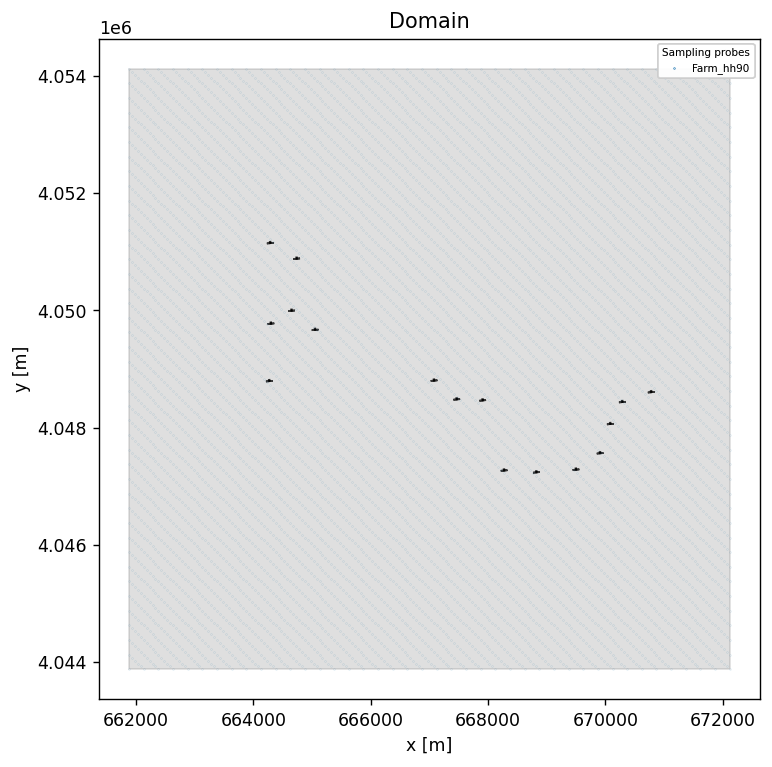

In [26]:
# Plot the domain
fig, ax = plt.subplots(figsize=(7,7), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_sampleprobes_style']  = "{'markersize':0.1, 'marker':'.', 'linestyle':'None', }"
case.popup_storteddata['plotdomain']['plot_sampleprobes_legend'] = "{'title':'Sampling probes', 'fontsize':6, 'loc':'upper right', 'markerscale':6}"
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = case.listboxpopupwindict['listboxsampling'].getitemlist() 
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY'
case.popup_storteddata['plotdomain']['plot_refineboxes']     = [] 
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_windnortharrows'] = False
start = time.time()
case.plotDomain(ax=ax, verbose=False, plotskip=5)

## Add some sampling for Thunder Ranch turbines

In [27]:
# Load the data from the database of all turbines
allturbsdf = pd.read_csv(summitcsv, low_memory=False)
#allturbsdf = updateturbs(allturbsdf)

In [28]:
# Get just the King Plains turbines
subset = [] 
for x in allturbsdf.iterrows():
    if x[1]['# name'].endswith('-TR'):
        subset.append(x[1])
subsetdf = pd.DataFrame(subset[:])

TR_turbinescsv = subsetdf.to_csv(index=False)
#print(subsetdf.to_csv(index=False))

In [29]:
case.setAMRWindInput('turbines_csvtextbox',  TR_turbinescsv)
case.setAMRWindInput('turbines_deleteprev', True)
#case.listboxpopupwindict['listboxactuator'].deleteall()
case.turbines_createAllTurbines()

In [30]:
outputoptions="outputvars:velocity;tke;temperature;velocity_mean outputfreq:10"

TRsamplingcsv = """
# CSV file should have columns withturbinescsv=
# name, type, upstream, downstream, lateral, below, above, n1, n2, options
name,      type, upstream, downstream, lateral, below, above, n1, n2, options
TRturbhh,  hubheight, 1020, 1020,       130,     0,     0,     11, 11, usedx:10 units:meter outputto:TRturbhh_ orientation:nacdir outputvars:velocity  {outputoptions}
TRsw,     streamwise, 1020, 1020,       0,       90,    130,   11, 11, usedx:10 units:meter outputto:TRsw_     orientation:nacdir outputvars:velocity   {outputoptions}
TRrotor,  rotorplane, 1020, 1020,       130,     ,      130,   11, 11, usedx:10 units:meter outputto:TRrotor_  orientation:nacdir outputvars:velocity noffsets:8  {outputoptions}
""".format(outputoptions=outputoptions)

In [31]:
case.setAMRWindInput('sampling_csvtextbox', TRsamplingcsv)
case.setAMRWindInput('sampling_deleteprev', False)

In [32]:
case.sampling_createAllProbes(verbose=False)
# Print out existing list of turbines
#print(case.listboxpopupwindict['listboxsampling'].getitemlist())

In [33]:
TRturbhh = [x for x in case.listboxpopupwindict['listboxsampling'].getitemlist() if x.endswith('_TRturbhh') ]
TRsw     = [x for x in case.listboxpopupwindict['listboxsampling'].getitemlist() if x.endswith('_TRsw') ]
TRrotor  = [x for x in case.listboxpopupwindict['listboxsampling'].getitemlist() if x.endswith('_TRrotor') ]

Time: 2.327582597732544


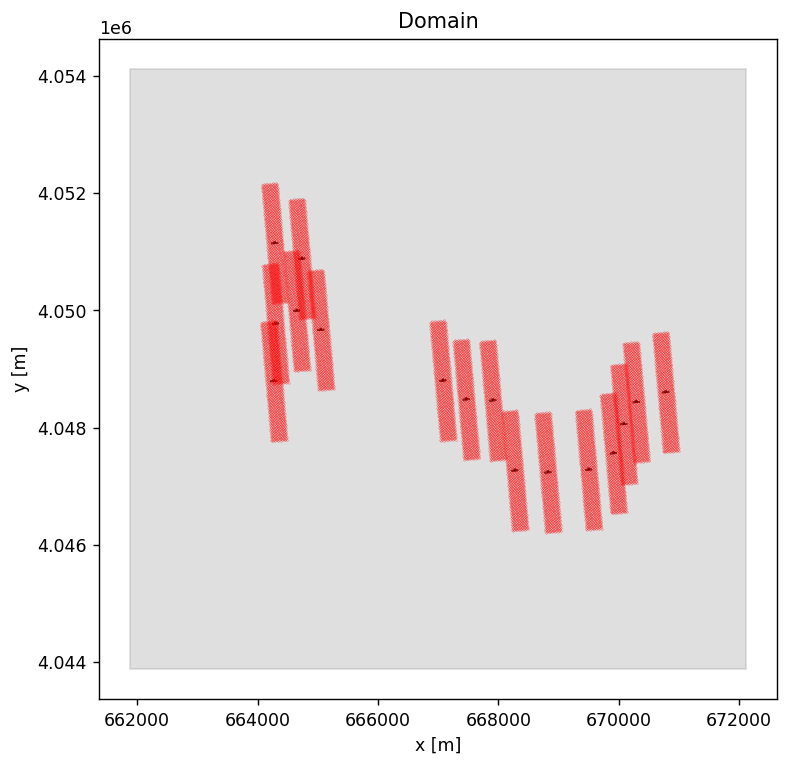

In [34]:
# Plot the domain
fig, ax = plt.subplots(figsize=(7,7), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_sampleprobes_style']  = "{'markersize':0.25, 'marker':'.', 'linestyle':'None', 'mfc':'r', 'markeredgecolor':'r'}"
case.popup_storteddata['plotdomain']['plot_sampleprobes_legend'] = "{}" #"{'title':'Sampling probes', 'fontsize':6, 'loc':'upper right', 'markerscale':6}"
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = TRturbhh #case.listboxpopupwindict['listboxsampling'].getitemlist() 
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY'#'YZ' 
case.popup_storteddata['plotdomain']['plot_refineboxes']     = [] #case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_windnortharrows'] = False
start = time.time()
case.plotDomain(ax=ax, verbose=False, plotskip=5)
end = time.time()
print("Time: "+repr(end - start))

"""
case.popup_storteddata['plotdomain']['plot_sampleprobes_style']  = "{'markersize':0.1, 'marker':'.', 'linestyle':'None', 'mfc':'g', 'markeredgecolor':'g'}"
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = KProtor #['p_hub']
start = time.time()
case.plotDomain(ax=ax, verbose=False)
end = time.time()
print("Time: "+repr(end - start))

case.popup_storteddata['plotdomain']['plot_sampleprobes_style']  = "{'markersize':0.1, 'marker':'.', 'linestyle':'None', 'mfc':'b', 'markeredgecolor':'b'}"
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = KPsw #['p_hub']
start = time.time()
case.plotDomain(ax=ax, verbose=False)
end = time.time()
print("Time: "+repr(end - start))
"""
ax.set_aspect('auto')
#ax.set_xlim([640000,  650000])
#ax.set_ylim([4025000, 4035000])

## Add hypre

In [35]:
hypreparams="""\
mac_proj.do_semicoarsening = true
mac_proj.bottom_solver = hypre
mac_proj.bottom_verbose = 0
mac_proj.max_coarsening_level = 0
mac_proj.bottom_rtol = 1.0e-12
mac_proj.bottom_atol = 1.0e-12

hypre.hypre_solver = GMRES
hypre.hypre_preconditioner = BoomerAMG
hypre.verbose = 0
hypre.bamg_verbose = 0
hypre.num_krylov = 20
hypre.bamg_max_levels = 5
hypre.bamg_num_sweeps = 1
hypre.bamg_coarsen_type = 8
hypre.bamg_interp_type = 6
hypre.bamg_cycle_type = 1
hypre.bamg_relax_order = 0
hypre.bamg_trunc_factor = 0.25
hypre.bamg_agg_num_levels = 1
hypre.bamg_agg_interp_type = 7
hypre.bamg_agg_pmax_elmts = 3
hypre.bamg_pmax_elmts = 3
hypre.bamg_strong_threshold = 0.57
hypre.recompute_preconditioner = 0
"""


usehypre = True

if usehypre:
    case.setAMRWindInput('mac_proj.mg_rtol', 1.0e-11)
    case.setAMRWindInput('mac_proj.mg_atol',  1.0e-9)    
    hyprelines = hypreparams.splitlines()
    for x in hyprelines:
        tokens=x.split('=')
        if len(tokens)>1:
            case.extradictparams[tokens[0]] = tokens[1].strip()



## Print the input file

### Set up the turbine case

In [36]:
os.chdir(cwd)

# remove all of the existing turbines, and add them back (with OpenFAST/ADM)
removeturbines(case)
allturbsdf = pd.read_csv(summitcsv, low_memory=False)
#allturbsdf = updateturbs(allturbsdf, changeKPturb='Summit_GE2.8-127_ADM')
turbinescsvstring = allturbsdf.to_csv(index=False)
case.setAMRWindInput('turbines_csvtextbox',  turbinescsvstring)
case.setAMRWindInput('turbines_createnewdomain', False)
case.setAMRWindInput('turbines_deleteprev', True)

# Go to the run directory
if not os.path.exists(farmrundir):
    os.makedirs(farmrundir)
os.chdir(farmrundir)

# Create all of the turbines
case.turbines_createAllTurbines()

# Write the input file
inputfile=case.writeAMRWindInput(outputfile)
if verbose: print(inputfile)


SET incflo.physics: ['ABL']


### Set up the no-turbine case

In [37]:
# # Run these steps to generate teh exact same case without any turbines
#os.chdir(cwd)
#removeturbines(case)
#inputfile=case.writeAMRWindInput(noturboutputfile)
#if verbose: print(inputfile)